In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/ExpertAnnotations.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/readme.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/Flickr8k.lemma.token.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/Flickr8k.token.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/CrowdFlowerAnnotations.txt
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/2366643786_9c9a830db8.jpg
/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/3368819708_0

In [2]:
## Kaggle directory
text_dir = "/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_text/"
img_dir = "/kaggle/input/flickr-8k-images/Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"

In [1]:
import os 
import pandas as pd 
import numpy as np
import spacy  
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F

/opt/homebrew/lib/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/opt/homebrew/lib/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [2]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1. Create PyTorch Dataset and Data Loaders

In [3]:
import string

spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        tokens = [tok.text.lower() for tok in spacy_eng.tokenizer(text)] 
        return tokens 
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        # Map tokens to indices using vocabulary's stoi mapping
        indexed_tokens = [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

        return indexed_tokens

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, choose_file, isTrain, transform=None, freq_threshold=10):
        self.root_dir = root_dir
        
        self.df = pd.read_csv(captions_file, sep='\t', names=['image', 'caption'])
        self.df['image'] = (self.df["image"]).str.split('#', n=1, expand=True)[0]
        
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df["caption"].tolist())
    
        
        self.choose_df = pd.read_csv(choose_file, names=['image'])
        if isTrain:
            validation_df = pd.read_csv(text_dir + 'Flickr_8k.devImages.txt',
                                    names=['image'])
            self.choose_df = pd.concat([self.choose_df, validation_df]).reset_index()
            
        self.df = self.df.loc[self.df['image'].isin(self.choose_df['image'].values)].reset_index(drop=True)
        
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.new('RGB', (356,356))
        try:
            img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        except:
            print("Skip images not in train set")

        if self.transform is not None:
            img = self.transform(img)

        #Numericalize the caption using the vocabulary
        numericalized_caption = [self.vocab.stoi["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        
        return imgs, targets

def get_loader(
    root_folder,
    annotation_file,
    choose_file,
    transform,
    batch_size=32,
    num_workers=4,
    shuffle=True,
    pin_memory=True,
    isTrain=True
):
    dataset = FlickrDataset(root_folder, annotation_file, choose_file, transform=transform, isTrain=isTrain)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset
    

In [5]:
## local directory
img_dir = "Dataset/Flicker8k_Dataset/"
text_dir = "Dataset/Flickr8k_text/"

In [6]:
# Train the model
batch_size=32
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_loader, dataset = get_loader(
    img_dir,
    text_dir + 'Flickr8k.token.txt',
    text_dir + 'Flickr_8k.trainImages.txt',
    transform=transform,
    num_workers=4,
    batch_size=batch_size,
    shuffle=True,
    isTrain=True
)


### 2. Model Architecture: Encoder-Decoder
For the model architecture, we'll implement an Encoder-Decoder framework with an attention mechanism: <br>
Encoder: Use a pre-trained CNN (ResNet50) to extract image features. <br>
Decoder: Implement an LSTM with attention to generate captions based on the image features and embedded captions.
#### 2.a) Encoder (Image Feature Extractor)
Use a pre-trained CNN (ResNet50) as the encoder to extract image features.

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        resnet = models.resnet50(pretrained=True)
        
        for param in resnet.parameters():
            param.requires_grad = False
                
        modules = list(resnet.children())[:-1]      
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

    def forward(self, images):

        features = self.resnet(images)
        # Reshape feature maps as a single feature vector
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        
        return features

#### 2.b) Decoder (Caption Generator)
Using Embedding layer from torch to generate embeddings from the vocabulary indexed captions

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        #self.lstm = nn.LSTMCell(embed_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        #print(features.shape, embeddings.shape)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

#### 2.c) Combine the CNN and RNN
Combine Encoder and Decoder as a whole model to pass images and captions & get output as captions

In [10]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

### 3. Train the Model
#### 3.a) Define Callbacks, load and save checkpoints

In [12]:
def save_checkpoint(state, filename="model_v1.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class Callbacks:
    def __init__(self, early_stop_patience, reduce_lr_factor, reduce_lr_patience, reduce_lr_min_lr):
        self.early_stop_patience = early_stop_patience
        self.reduce_lr_factor = reduce_lr_factor
        self.reduce_lr_patience = reduce_lr_patience
        self.reduce_lr_min_lr = reduce_lr_min_lr

        self.early_stop_counter = 0
        self.best_val_loss = float('inf')
        self.optimizer = None
        self.scheduler = None

    def early_stop(self, val_loss):
        if val_loss < self.best_val_loss:
            self.early_stop_counter = 0
            self.best_val_loss = val_loss
        else:
            self.early_stop_counter += 1

        if self.early_stop_counter >= self.early_stop_patience:
            return True
        else:
            return False

    def reduce_lr(self, val_loss):
        if val_loss > self.best_val_loss:
            self.scheduler.step(val_loss, self.reduce_lr_factor)
            if self.optimizer.param_groups[0]['lr'] < self.reduce_lr_min_lr:
                return True  # Stop training
        return False

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_scheduler(self, scheduler):
        self.scheduler = scheduler

#### 3.b) Define Hyperparameters

In [11]:
# Hyperparameters
hidden_size = 256
embed_size = 256
vocab_size = len(dataset.vocab)
learning_rate = 1e-03
num_epochs = 10
num_layers = 1
load_model = False
save_model = True
train_CNN = False

In [14]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("Wandb") 

wandb.login(key=my_secret)

wandb: Currently logged in as: kritz2399 (kritika_23). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### 3.c) Define train function

In [15]:
def train():

    # Log hyperparameters
    wandb.init(project="dl_at3")
    config = wandb.config
    config.epochs = 10
    config.batch_size = 32
    config.vocab_size = len(dataset.vocab)
    config.optimizer = 'adam'
    config.loss = 'cross_entropy_loss'
    config.metrics = ['loss']
    
    step = 0
    
    # initialize model, loss, callbacks, etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    callbacks = Callbacks(early_stop_patience=5, reduce_lr_factor=0.5, reduce_lr_patience=5, reduce_lr_min_lr=1e-6)
    callbacks.set_optimizer(optimizer)
    # Initialize scheduler and set it in Callbacks
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)
    callbacks.set_scheduler(scheduler)

    if load_model:
        step = load_checkpoint(torch.load("model_v1.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
            

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
        
        print('Epoch {} completed with loss {}'.format(epoch+1, loss))
        wandb.log({"train_loss": loss}, step=epoch+1)
        checkpoint_filepath = f'captioning_model_v1_{epoch+1}.pth'
        torch.save(model, checkpoint_filepath)
        
        if callbacks.early_stop(loss):
            print("Early stopping triggered. Stopping training.")
            break

        if callbacks.reduce_lr(loss):
            print("Minimum learning rate reached. Stopping training.")
            break
            
    # Log the model in W&B and link it to the registry
    artifact = wandb.Artifact(name='image-captioning', type='model')
    artifact.add_file(checkpoint_filepath)
    wandb.run.log_artifact(artifact)

    wandb.finish()
    
    return model

In [16]:
model = train()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s] 


=> Saving checkpoint


Epoch 1 completed with loss 2.698019027709961
=> Saving checkpoint


Epoch 2 completed with loss 2.657137393951416
=> Saving checkpoint


Epoch 3 completed with loss 2.357248067855835
=> Saving checkpoint


Epoch 4 completed with loss 2.1638875007629395
=> Saving checkpoint


Epoch 5 completed with loss 2.1715686321258545
=> Saving checkpoint


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1006: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6 completed with loss 2.005392551422119
=> Saving checkpoint


Epoch 7 completed with loss 1.882344365119934
=> Saving checkpoint


Epoch 8 completed with loss 1.5690786838531494
=> Saving checkpoint


Epoch 9 completed with loss 1.787095069885254
=> Saving checkpoint


Epoch 10 completed with loss 1.9016156196594238


train_loss,██▆▅▅▄▃▁▂▃
train_loss,1.90162


### 4. Evaluate on test set - calculate BLEU scores

In [20]:
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_loader, test_dataset = get_loader(
    img_dir,
    text_dir + 'Flickr8k.token.txt',
    text_dir + 'Flickr_8k.testImages.txt',
    transform=transform,
    num_workers=4,
    shuffle=False,
    isTrain=False
)

model = torch.load("/kaggle/working/captioning_model_v1_8.pth")
model.eval()

CNNtoRNN(
  (encoderCNN): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
    

In [21]:
from nltk.translate.bleu_score import corpus_bleu
references=[]
candidates=[]

for idx,(image,caption) in enumerate(iter(test_loader)):
    for k in range(image.shape[0]):
        img = image[k].unsqueeze(0)
        caps = model.caption_image(img.to(device), dataset.vocab)
        reference=[dataset.vocab.itos[i] for i in caption[:,k].tolist() if dataset.vocab.itos[i]!="<PAD>"]
        references.append(reference)
        candidates.append(caps)

In [22]:
print("bleu 1 score : ",corpus_bleu(references,candidates,weights=(1,0,0,0)))
print("bleu 2 score : ",corpus_bleu(references,candidates,weights=(0.5,0.5,0,0)))
print("bleu 3 score : ",corpus_bleu(references,candidates,weights=(0.33,0.33,0.33,0)))
print("bleu 4 score : ",corpus_bleu(references,candidates,weights=(0.25,0.25,0.25,0.25)))

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


bleu 1 score :  0.13659450457951708
bleu 2 score :  0.36958693778259677
bleu 3 score :  0.5184333903183279
bleu 4 score :  0.6079366231628069


### 5. Analyse real and predicted captions for trained images

In [23]:
def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    
    # First Image
    test_img1 = transform(Image.open(img_dir+"1001773457_577c3a7d70.jpg").convert("RGB")).unsqueeze(0)
    print("Example 1 CORRECT: A black dog and a spotted dog are fighting")
    print("Example 1 OUTPUT: " + " ".join(model.caption_image(test_img1.to(device), dataset.vocab)))
    print("\n")
    
    # Second Image
    test_img2 = transform(Image.open(img_dir+"102351840_323e3de834.jpg").convert("RGB")).unsqueeze(0)
    
    print("Example 2 CORRECT: A man is drilling through the frozen ice of a pond .")
    print("Example 2 OUTPUT: " + " ".join(model.caption_image(test_img2.to(device), dataset.vocab)))
    print("\n")
    
    # Third Image
    test_img3 = transform(Image.open(img_dir+"1007320043_627395c3d8.jpg").convert("RGB")).unsqueeze(0)
    
    print("Example 3 CORRECT: A little girl climbing on red roping .")
    print("Example 3 OUTPUT: " + " ".join(model.caption_image(test_img3.to(device), dataset.vocab)))
    print("\n")
    
    # Fourth Image
    test_img4 = transform(Image.open(img_dir+"1015118661_980735411b.jpg").convert("RGB")).unsqueeze(0)
    
    print("Example 4 CORRECT: A young boy runs aross the street .")
    print("Example 4 OUTPUT: "+ " ".join(model.caption_image(test_img4.to(device), dataset.vocab)))
    print("\n")
    
    # Fifth Image
    test_img5 = transform(Image.open(img_dir+"1052358063_eae6744153.jpg").convert("RGB")).unsqueeze(0)
    print("Example 5 CORRECT: A boy takes a jump on his skateboard while another boy with a skateboard watches .")
    print("Example 5 OUTPUT: "+ " ".join(model.caption_image(test_img5.to(device), dataset.vocab)))
    print("\n")

In [24]:
print_examples(model, device, dataset)

Example 1 CORRECT: A black dog and a spotted dog are fighting
Example 1 OUTPUT: <SOS> two dogs are playing together on the grass . <EOS>


Example 2 CORRECT: A man is drilling through the frozen ice of a pond .
Example 2 OUTPUT: <SOS> a man in a red and white boat is <UNK> in the water . <EOS>


Example 3 CORRECT: A little girl climbing on red roping .
Example 3 OUTPUT: <SOS> a boy in a red shirt is jumping off a swing . <EOS>


Example 4 CORRECT: A young boy runs aross the street .
Example 4 OUTPUT: <SOS> a boy in a red shirt is walking on a sidewalk with a <UNK> in the background . <EOS>


Example 5 CORRECT: A boy takes a jump on his skateboard while another boy with a skateboard watches .
Example 5 OUTPUT: <SOS> a man in a red shirt and jeans is walking down a sidewalk . <EOS>




### 6. Take inference on unseen images

In [12]:
## loading the model version which has lowest loss
model_v1 = torch.load("captioning_model_v1_8.pth", map_location=torch.device('cpu'))
model_v1.eval()

transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

In [19]:
import matplotlib.pyplot as plt

def caption_all_images(image_paths, model):
    count = 0
    for img_path in image_paths:
        if (img_path.endswith(".png") or img_path.endswith(".jpg")):
            count = count + 1
            print("Image ", count)
            plt.figure(figsize=(6,4))
            full_path = 'test_examples/' + img_path
            img = transform(Image.open(full_path).convert("RGB")).unsqueeze(0)
            caption = ' '.join(model.caption_image(img.to(device), dataset.vocab)[1:-1]) # remove <SOS> and <EOS>
            read_img = plt.imread(full_path)
            plt.imshow(np.real(read_img))
            plt.axis("on")
            plt.title(caption)
            plt.show()
            print("\n")

Image  1


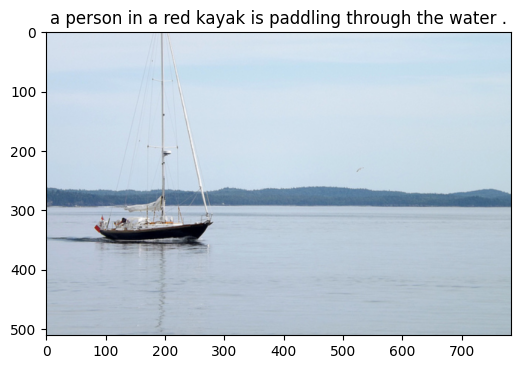



Image  2


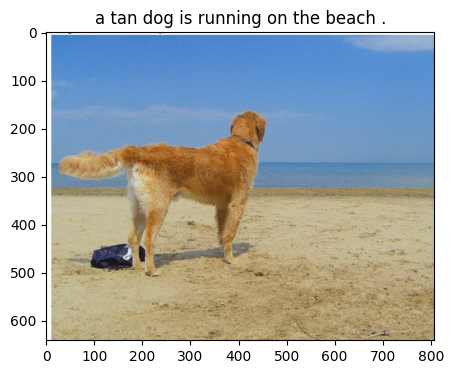



Image  3


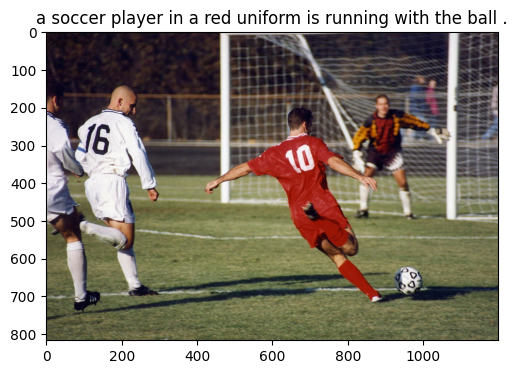



Image  4


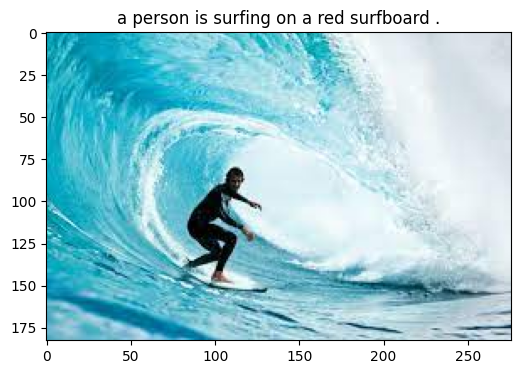



Image  5


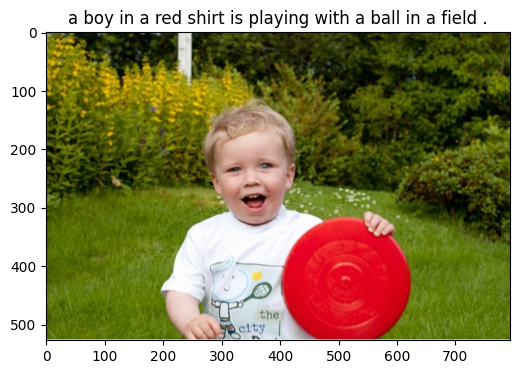



Image  6


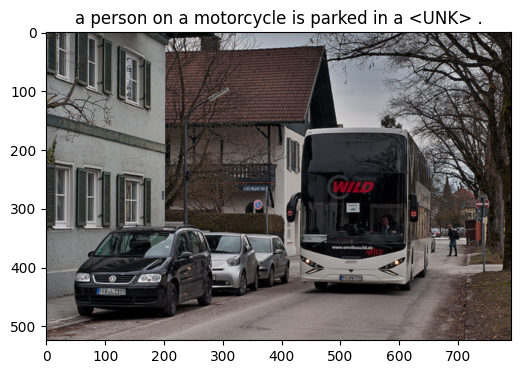

In [20]:
caption_all_images(os.listdir('test_examples'), model_v1)